# 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。


事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。


[sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)



In [2]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, isspmatrix
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor as RFR

%matplotlib inline

In [3]:
# HomeCreditDefaltRiskを読み込み
data = pd.read_csv("application_train.csv")

df = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)


In [4]:
# カテゴリ変数をラベルエンコーディング
# カテゴリ変数(dtype=objectの列)を抜き出す

def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']

    return feats

# カテゴリ変数を数値化
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df


obj= _get_categorical_features(df)
print(obj)
print(len(obj))

_factorize_categoricals(df, obj)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
16


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 欠損値を平均値で置換
df.fillna(df.median(), inplace=True)
df

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307507,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307508,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Xとyに代入

X = df.values
y = data['TARGET'].values
y

array([1, 0, 0, ..., 0, 1, 0])

In [6]:
# KFoldのインスタンス

kf = KFold(n_splits=5)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [249]:
# ロジスティック回帰
def SGDC(x_train, y_train, x_test):
    sgdc = SGDClassifier(loss="log")
    sgdc.fit(x_train, y_train)
    y_pred_log = sgdc.predict_proba(x_test)[:,1]

    return y_pred_log

In [8]:
# ロジスティック回帰
def LR_func(x_train, y_train, x_test):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(x_train, y_train)
    y_pred_log = lr.predict(x_test)

    return y_pred_log

In [9]:
# SVM
def SVM_func(x_train, y_train, x_test):
    svm = SVC(kernel='rbf', gamma='scale', random_state=None)
    svm.fit(x_train, y_train)
    y_pred_svm = svm.predict(x_test)
    
    return y_pred_svm

In [11]:
# 出力関数
outlist = {}

def output(y, model, label,outlist={}):
    auc = roc_auc_score(y, model)

    print('auc_score = ', auc)

    outlist[label] = auc
    return outlist

In [12]:
# 標準化関数
def StandardScaler_func(x_train, x_test):
    sc = StandardScaler()
    sc.fit(x_train)

    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    return x_train_std, x_test_std

In [250]:
# KFoldで分割、標準化、SGDClassifierで推定、評価(ROC-AUC)まで

cnt = 0

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_std, x_test_std = StandardScaler_func(X_train, X_test)
    y_pred_svm = SGDC(x_train_std, y_train, x_test_std)
    
    output(y_test, y_pred_svm, cnt, outlist)
    cnt += 1

TRAIN: [10000 10001 10002 ... 49997 49998 49999] TEST: [   0    1    2 ... 9997 9998 9999]
auc_score =  0.7267048968503991
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [10000 10001 10002 ... 19997 19998 19999]
auc_score =  0.7106895030910256
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [20000 20001 20002 ... 29997 29998 29999]
auc_score =  0.7033824149632616
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [30000 30001 30002 ... 39997 39998 39999]
auc_score =  0.7284125108875696
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 49997 49998 49999]
auc_score =  0.6981392179765281


In [251]:
# 平均auc_score
tmp = []
for i in range(len(outlist)):
    tmp.append(outlist[i])
ave = sum(tmp) / len(tmp)
print("このモデルの平均auc_scoreは{:.５f}です。".format(ave))
result_dict={}
result_dict['SGDC'] = ave

このモデルの平均auc_scoreは0.71347です。


# 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。


scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。


[sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [16]:
# 探索空間をparameters として設定
# 今回はカーネル二つとCを0.1〜100、rbfのgammaを0.001,0.0001まで
parameters = { 'penalty':['l1','l2'], 'eta0': [0.1, 0.01, 0.001]}

In [26]:
# グリッドサーチする
sgdc = SGDClassifier(loss="log")
clf = GridSearchCV(sgdc, parameters, cv=2, scoring="roc_auc")

In [27]:
%%timeit -r 1 -n 1
clf.fit(X, y)

2min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
cv_result = pd.DataFrame(clf.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta0,param_penalty,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,17.503570,14.749601,0.060827,0.003353,0.1,l1,"{'eta0': 0.1, 'penalty': 'l1'}",0.565089,0.581080,0.573085,0.007995,3
1,10.968307,9.735535,0.056890,0.001112,0.1,l2,"{'eta0': 0.1, 'penalty': 'l2'}",0.580356,0.601722,0.591039,0.010683,1
2,18.246402,12.090070,0.063375,0.002855,0.01,l1,"{'eta0': 0.01, 'penalty': 'l1'}",0.584394,0.596678,0.590536,0.006142,2
3,8.126626,5.224497,0.069419,0.008151,0.01,l2,"{'eta0': 0.01, 'penalty': 'l2'}",0.559044,0.580705,0.569875,0.010830,4
4,20.639744,12.905835,0.069855,0.006652,0.001,l1,"{'eta0': 0.001, 'penalty': 'l1'}",0.547730,0.553001,0.550365,0.002636,6
5,9.965922,7.994643,0.067082,0.007217,0.001,l2,"{'eta0': 0.001, 'penalty': 'l2'}",0.577759,0.551530,0.564645,0.013114,5


In [29]:
best_clf = clf.best_estimator_
best_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [253]:
# モデル再設定
def SGDC_2(x_train, y_train, x_test):
    sgdc2 = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
    sgdc2.fit(x_train, y_train)
    y_pred_log = sgdc2.predict_proba(x_test)[:,1]

    return y_pred_log

In [254]:
# KFoldで分割、標準化、SGDClassifierで推定、評価(正答率)まで

cnt = 0
outlist2 = {}

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_std, x_test_std = StandardScaler_func(X_train, X_test)
    y_pred_svm = SGDC_2(x_train_std, y_train, x_test_std)
    
    output(y_test, y_pred_svm, cnt, outlist2)
    cnt += 1

TRAIN: [10000 10001 10002 ... 49997 49998 49999] TEST: [   0    1    2 ... 9997 9998 9999]
auc_score =  0.7128505928564876
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [10000 10001 10002 ... 19997 19998 19999]
auc_score =  0.7069743935622246
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [20000 20001 20002 ... 29997 29998 29999]
auc_score =  0.7092270700010024
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [30000 30001 30002 ... 39997 39998 39999]
auc_score =  0.7283966317435964
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 49997 49998 49999]
auc_score =  0.7245067856944213


In [255]:
# auc_score平均値
tmp = []
for i in range(len(outlist2)):
    tmp.append(outlist2[i])
ave = sum(tmp) / len(tmp)
print("このモデルの平均auc_scoreは{:.5f}です。".format(ave))
result_dict['SGDC2'] = ave

このモデルの平均auc_scoreは0.71639です。


# 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。



参考にしたnotebook

[kaggle notebook](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

[other site](https://hayashibe.jp/note/ml/dl/imporove_generalization)

いろんなnotebookを見ていると、lightGBMを利用している人がかなり多い。
パラメータチューニングのやり方など、情報も多いため、lightGBMを利用してみる。



汎化誤差の種類と典型的な対策

近似誤差: モデルの表現力が足りないことによる誤差
パラメータを増やして自由度を上げる

推定誤差: 偏った事例を使ったことによる誤差 -> 過学習
訓練データを増やす，パラメータを減らして自由度を下げる

最適化誤差: 目的関数を最小化するアルゴリズムによる誤差
洗練された最適化アルゴリズムを使う

推定誤差の低減
以下の手法は組み合わせられる

適切なネットワーク構造を選ぶ

L2正則化
パラメータが動く範囲を0周辺に制約する

early stopping
訓練データの誤差は基本的にはパラメータ更新のたびに下がり続ける
しかし，開発データではそうでない場合が有り，そのような場合は更新を止める
ただし局所解になってしまう可能性はある

学習率減衰
開発データで改善がみられない場合は更新率を下げる
L2正則化と異なり，開発データでの誤差が増え始めたときにパラメータに制約がかかる

パラメータ共有
類似した目的をもった要素間で共有する
RNNやCNNはパラメータを共有している一例
複数のタスクの類似性を仮定して，複数タスクを同時学習するマルチタスク学習でもパラメータ共有がしばしば使われる

パラメータ結束
完全に同じにするのではなく，2つのパラメータが近くなるような制約を目的関数に追加する

事前学習
別の補助タスクで学習したパラメータを使う
NLPではembeddingsをよく使う
対話モデルの強化学習の前に，教師有り学習でのパラメータを使う例など

アンサンブル
committee machinesやmodel averagingなど
バギング: 訓練データから複数の部分集合を作る

dropout
訓練時に状態変数の一部をランダムに0にする


最適化誤差の低減

ゼフィア初期化

IRNN

活性化関数
sigmoidやtanhは出力が有界で計算が安定するが，微分係数が1未満なので勾配消失が起きやすい
ReLUは正値入力には線形で微分係数は1なので，勾配消失が起きない
maxoutなども

カリキュラム学習
簡単な事例から学習を始める

正規化

バッチ正規化

各層の依存関係によって状態変数の値が大きく変化することを防ぐ
大きな学習率でも勾配法が安定する
ミニバッチ内の隠れ状態ベクトルの要素を平均0分散1となるよう変換する
誤差逆伝播法の中でも平均分散を計算する操作も含めて微分を計算することがある

層正規化

ミニバッチを使わずに正規分布の入力を仮定して解析的に正規化する方法

Adam

[other site 2](https://amalog.hateblo.jp/entry/hyper-parameter-search)

[other site 3](https://www.codexa.net/lightgbm-beginner/)

In [217]:
# lightGBMの利用
'''
kaggleのやつをそのまま載せてみる。
lgbの利用法を学ぶ。

'''

import lightgbm as lgb # import

N_FOLDS = 5 # 分割数、最新だとn_splitとかになってるかも。
MAX_EVALS = 5 # 繰り返し探索する数

In [66]:
# Sample 16000 rows (10000 for training, 6000 for testing) 
# サンプル抜き出してる。パラメータチューニングもそうだし、最終的に全部使うことってほぼないから、全部で走らせる必要性は全くないかも。
features = data.sample(n = 16000, random_state = 42)

# Only numeric features
# 同様に特徴量エンジニアリングする必要もないので、とりあえず数字の特徴量だけ抜き出し
features = features.select_dtypes('number')

# Extract the labels
# 目的変数抽出と、特徴量からIDと目的変数を削除
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
# train_test_split,10000と6000に
T


In [54]:
# サイズ確認
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


In [55]:
# Create a training and testing dataset
# データセットを作成。これの必要性はわかってない
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [63]:
# Get default hyperparameters
# modelを設定して、デフォルトのハイパーパラメータを取得
model = lgb.LGBMClassifier()
default_param = model.get_params()
print(default_param)

# Remove the number of estimators because we set this to 10000 in the cv call
# n_estimatorsは削除。別名num_boost_round, num_iterations, n_iterなど。繰り返す回数の指定。
# 正確にはブースティングを行う決定木の数？
# 今回は１００００を指定して、early_stoppingで100を指定している。
del default_param['n_estimators']

# Cross validation with early stopping
# earlystopping設定して、クロスバリデーションを行う。metrics評価方法はauc。
cv_results = lgb.cv(default_param, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [65]:
# 結果
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.71266 with a standard deviation of 0.02191.
The optimal number of boosting rounds (estimators) was 25.


In [59]:
# Optimal number of esimators found in cv
# 最適なround数は25だったので、それを設定
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
# モデルを使った訓練と予測
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))


The baseline model scores 0.72831 ROC AUC on the test set.


目的関数はハイパーパラメータを取り込んで、スコアを表す値を出力します。伝統的に最適化では、これは最小化するスコアですが、ここでは、もちろん最大化したいROC AUCがスコアとなります。後にベイズ最適化に入ると、最小化する値を使用しなければならないので、1-ROC AUCをスコアとして取ることができます。目的関数の途中で何が発生するかは問題によって異なりますが、今回の問題では、指定したモデルのハイパーパラメータを用いてクロスバリデーションを行い、クロスバリデーションROC AUCを取得します。そして、このスコアを用いて、最適なモデルハイパーパラメータの値を選択します。

最大化する値を返すだけでなく、目的関数はハイパーパラメータと探索の繰り返しを返します。これらの結果から、検索中に発生したことをさかのぼって調べることができます。以下のコードは、グリッド検索とランダム検索の両方に使用できる単純な目的関数を実装しています。

In [67]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    # earltstoppingするのでestimators一旦削除
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
    # Perform n_folds cross validation
    #n_folds でクロスバリデーション実行
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    # リザルトを返す
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [75]:

score, params, iteration = objective(default_param, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))


The cross-validation ROC AUC was 0.71266.
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'n_estimators': 25}
1


ここまでで、パラメータを入れてクロスバリデーションを行う関数が完成。
続いてハイパーパラメータを確認していく。


In [72]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

これらの中には、サイレント、客観的、ランダム状態、n_jobs のように調整する必要のないものもあり、おそらく最も重要なハイパーパラメータである、訓練された個々の学習者の数である n_estimators (num_boost_rounds や反復回数とも呼ばれる) を決定するために、早期停止を使用します。例えば、min_child_samplesとmin_child_weightは、葉の観測要件の最小値を調整することで、個々の決定木の複雑さを制限するので、我々は1つだけ調整します。しかし、最適化すべきハイパーパラメータはまだたくさんあるので、10個のハイパーパラメータを選んで調整します。

ハイパーパラメータのグリッドを選択することは、おそらくハイパーパラメータのチューニングの中で最も難しい部分です。さらに，ハイパーパラメータはお互いに複雑な相互作用を持っているので，一度に1つずつチューニングするだけではうまくいきません．

モデルを使った経験があれば，ハイパーパラメタの最適値が一般的にどこにあるのか，あるいは良い探索空間とは何かを知っているかもしれません．しかし、あまり経験がない場合は、単純に広い探索空間を定義して、どこかに最良の値があることを期待することができます。通常、最初にメソッドを使うときは、デフォルト値を中心とした広い探索空間を定義します。そして、ハイパーパラメータのいくつかの値の方がうまくいく傾向があることがわかったら、その値を中心に検索を集中させます。

10個のハイパーパラメータの完全なグリッドを以下に定義します。ディショナリーの各値はリストでなければならないので、各ハイパーパラメータの値の範囲を定義するために、range, np.linspace, np.logspaceを組み合わせたリストを使っています。

In [73]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

注意すべき点の1つは、boosting_typeがgossの場合、サブサンプル(これは、確率的勾配ブースティングとして知られている手法で、学習データの一部の行のみで学習することを意味します)を使用できないことです。したがって、boosting_type=gossの場合、サブサンプルを1.0（つまり、すべての行を使用する）に設定するロジックがアルゴリズムに必要になります。以下の例のように、ハイパーパラメータのセットをランダムに選択し、ブースティング・タイプが "goss "である場合、サブサンプルを1.0に設定します。

In [85]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


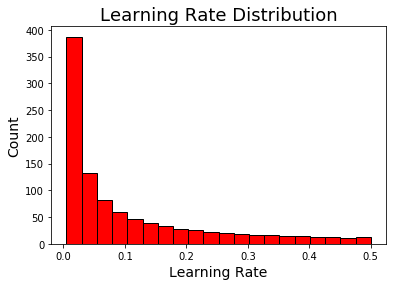

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [84]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


In [86]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    # returnするDF
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [87]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.72800

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 621,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [88]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73432 ROC AUC on the test set.


もしこれをデータセット全体で実行したいのであれば、これらの関数を自由にスクリプトに入れてください。しかし、非常に小さなハイパーパラメータグリッドを持っていない限り、グリッド検索を使用しないことをお勧めします。後で、上記で使用したのと同じ小さなデータのサブセットでグリッド検索とランダム検索を1000回繰り返した結果を見てみましょう。私は、完全なデータ上でグリッド検索の任意の形式を実行しようとしていません（そして、おそらくこの方法を試すことはありません）。

### グリッド検索でクロスバリデーションを行うのは効率が悪い？

ランダム検索は、グリッド検索に比べて驚くほど効率的です。グリッド検索は最終的にハイパーパラメータの最適値を見つけますが（それらがグリッド内にあると仮定して）、ランダム検索は通常、はるかに少ない反復回数で「十分に近い」値を見つけることができます。グリッド検索は、グリッド内のすべての組み合わせを評価しなければならないため、ハイパーパラメータ検索空間の有望でない領域を評価するのに多くの時間を費やしてしまいます。対照的にランダム探索は，探索空間を探索するのが得意なので，通常ははるかに少ない反復回数でハイパーパラメータの良い組み合わせを見つけることができます．

この記事で紹介されているように，ランダム探索はその有効性から，おそらく最初に試してみるべきハイパーパラメータ最適化手法です．これは非情報化（過去の評価結果に依存しない）手法であるにもかかわらず、ランダム検索は通常、デフォルトよりも良い値を見つけることができ、実行も簡単です。

ランダム検索はアルゴリズムとしても考えることができます：グリッドから次のハイパーパラメータのセットをランダムに選択します。以下のように、各ハイパーパラメータに対して1つのランダムな値を選択することで、ハイパーパラメータの辞書を作成できます（ここでもサブサンプリングを考慮に入れています）。

In [91]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

次に、random_search関数を定義します。これは、次のハイパーパラメータ値を選択するために使用される方法を除いて、grid_searchと同じ一般的な構造をとります。さらに、ランダム検索は常に検索の繰り返し回数に制限を設けて実行されます。

In [93]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

結論
モデルチューニングは、特定の問題に対して最適な機械学習モデルのハイパーパラメータを見つけるプロセスである。ランダム検索とグリッド検索は、グリッド領域からハイパーパラメータ値を選択して検索するハイパーパラメータチューニングのための2つの均一化された方法である。ハイパーパラメータ・チューニングの4つの部分は以下の通りである．

・objective function：ハイパーパラメータを取り込み，最大化または最小化したいクロスバリデーションスコアを返す．

・Domain of hyperparameters:検索したい値

・Algorithm: 目的関数で評価する次のハイパーパラメータ値を選択する方法

・result：ハイパーパラメータの履歴とクロスバリデーションのスコア

これらの4つの部分は、グリッド検索とランダム検索、およびベイズ最適化（自動ハイパーパラメタチューニングの一形態）に適用されます。このノートでは，ランダム探索とグリッド探索の両方を縮小したデータセットに実装し，その結果を検証し，最適なハイパーパラメータを（このカーネルからの）完全なデータセットに変換してみました．ちょっとした注意点として、クロスバリデーションを使ってハイパーパラメータを訓練データに合わせて調整していることを覚えておくことが重要です。小さいデータセットから得られた最適なハイパーパラメータは、完全なデータセットではそれほどうまく機能しませんでしたが、この2つのチューニング方法の背後にある考え方を見ることができました。さらに、ここで開発された関数は、勾配ブーストマシンだけでなく、あらゆるデータセットや機械学習モデルに適用することができます。

ランダム探索は実際にはかなりうまくいくことがわかったが（探索領域を探索するのが得意なので）、過去の評価結果を次のハイパーパラメータ値の選択に利用しないので、推論的な手法とは言えない。これまで見てきたように、目的関数の評価には時間がかかるため、過去の評価結果を使って、目的関数で次に試すべき最適な値を推論する方が良いでしょう。今後の作業では、ベイズ最適化を使用した自動化されたハイパーパラメータチューニングの実装を検討します。

モデルの性能はハイパーパラメータ値の選択に大きく依存するため、ハイパーパラメータのチューニングは機械学習パイプラインの重要な部分です。ランダム探索とグリッド探索は、モデルのチューニングを開始するための2つの適切な方法であり（少なくとも手動でチューニングするよりは優れている）、データサイエンスのスキルセットに持っておくべき重要なツールである。ご愛読ありがとうございました。

いつものように、私はフィードバックや建設的な批判を歓迎します。私は[Towards Data Science](https://medium.com/@williamkoehrsen/)
に執筆しており、Twitterでは [twitter](https://twitter.com/koehrsen_will) で連絡を取ることができます。

遺言

[other site 4](https://aws.amazon.com/jp/blogs/news/amazon-sagemaker-automatic-model-tuning-now-supports-random-search-and-hyperparameter-scaling/)

[other site 5](https://medium.com/@yuyasugano/%E3%83%99%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96-optuna-with-sagemaker-%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%A8%E8%A9%95%E4%BE%A1%E3%82%92%E6%99%82%E7%9F%AD%E3%81%97%E3%81%A6%E5%8A%B9%E7%8E%87%E5%8C%96-afa203216ea9)

○結論
* 機械学習モデルはlgb
* ハイパーパラメータ探索はベイズ最適化(optuna)を使う


In [112]:
# 使い方

import optuna
 
# 目的関数
def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    score = (x - 2) ** 2
    print('x: %1.3f, score: %1.3f' % (x, score))
    
    return score
 
    
# 最適化（score：最小化, トライアル数：100）
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# 最大化、トライアル数：100、タイムアウト600sec
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100, timeout=600)

x: 4.511, score: 6.305


[I 2020-08-05 15:21:38,805] Trial 0 finished with value: 6.304591160895867 and parameters: {'x': 4.510894494178492}. Best is trial 0 with value: 6.304591160895867.


x: 4.021, score: 4.083


[I 2020-08-05 15:21:38,811] Trial 1 finished with value: 4.082530432536757 and parameters: {'x': 4.020527265972117}. Best is trial 1 with value: 4.082530432536757.


x: 2.036, score: 0.001


[I 2020-08-05 15:21:38,817] Trial 2 finished with value: 0.0012617285986140647 and parameters: {'x': 2.0355208192278003}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.350, score: 2.723


[I 2020-08-05 15:21:38,821] Trial 3 finished with value: 2.723264257421527 and parameters: {'x': 0.3497684230928293}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.333, score: 1.776


[I 2020-08-05 15:21:38,825] Trial 4 finished with value: 1.7758807282068203 and parameters: {'x': 3.332621749862586}. Best is trial 2 with value: 0.0012617285986140647.


x: 4.998, score: 8.990


[I 2020-08-05 15:21:38,828] Trial 5 finished with value: 8.989733639254323 and parameters: {'x': 4.9982884516427575}. Best is trial 2 with value: 0.0012617285986140647.


x: 4.483, score: 6.164


[I 2020-08-05 15:21:38,831] Trial 6 finished with value: 6.163694121227721 and parameters: {'x': 4.482678819587367}. Best is trial 2 with value: 0.0012617285986140647.


x: 5.706, score: 13.733


[I 2020-08-05 15:21:38,835] Trial 7 finished with value: 13.733140621890605 and parameters: {'x': 5.705825228190154}. Best is trial 2 with value: 0.0012617285986140647.


x: -0.172, score: 4.717


[I 2020-08-05 15:21:38,838] Trial 8 finished with value: 4.717421894584388 and parameters: {'x': -0.1719626825947973}. Best is trial 2 with value: 0.0012617285986140647.


x: 6.751, score: 22.568


[I 2020-08-05 15:21:38,841] Trial 9 finished with value: 22.567915196547762 and parameters: {'x': 6.750569986490859}. Best is trial 2 with value: 0.0012617285986140647.


x: -5.201, score: 51.851


[I 2020-08-05 15:21:38,845] Trial 10 finished with value: 51.85080402305171 and parameters: {'x': -5.200750240291057}. Best is trial 2 with value: 0.0012617285986140647.


x: 9.694, score: 59.203


[I 2020-08-05 15:21:38,849] Trial 11 finished with value: 59.20304435389547 and parameters: {'x': 9.69435145765356}. Best is trial 2 with value: 0.0012617285986140647.


x: -0.103, score: 4.424


[I 2020-08-05 15:21:38,853] Trial 12 finished with value: 4.423659430746706 and parameters: {'x': -0.10324973095129764}. Best is trial 2 with value: 0.0012617285986140647.


x: -3.636, score: 31.761


[I 2020-08-05 15:21:38,857] Trial 13 finished with value: 31.76108035631113 and parameters: {'x': -3.6356969716540943}. Best is trial 2 with value: 0.0012617285986140647.


x: 9.907, score: 62.522


[I 2020-08-05 15:21:38,861] Trial 14 finished with value: 62.52226949424053 and parameters: {'x': 9.907102471464533}. Best is trial 2 with value: 0.0012617285986140647.


x: -9.844, score: 140.270


[I 2020-08-05 15:21:38,864] Trial 15 finished with value: 140.27016025783465 and parameters: {'x': -9.843570418494359}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.840, score: 0.026


[I 2020-08-05 15:21:38,868] Trial 16 finished with value: 0.025630922940917233 and parameters: {'x': 1.8399033949737933}. Best is trial 2 with value: 0.0012617285986140647.


x: -2.659, score: 21.707


[I 2020-08-05 15:21:38,872] Trial 17 finished with value: 21.707075679633704 and parameters: {'x': -2.659085283575919}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.768, score: 0.054


[I 2020-08-05 15:21:38,876] Trial 18 finished with value: 0.05371569938221425 and parameters: {'x': 1.7682335240328872}. Best is trial 2 with value: 0.0012617285986140647.


x: 7.881, score: 34.587


[I 2020-08-05 15:21:38,880] Trial 19 finished with value: 34.58683512794408 and parameters: {'x': 7.881057313778202}. Best is trial 2 with value: 0.0012617285986140647.


x: -2.368, score: 19.078


[I 2020-08-05 15:21:38,883] Trial 20 finished with value: 19.077779123359626 and parameters: {'x': -2.3678117087804536}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.312, score: 0.473


[I 2020-08-05 15:21:38,887] Trial 21 finished with value: 0.4731672872294755 and parameters: {'x': 1.3121284369669906}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.234, score: 0.055


[I 2020-08-05 15:21:38,892] Trial 22 finished with value: 0.05476143348895168 and parameters: {'x': 2.2340116097311236}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.166, score: 0.028


[I 2020-08-05 15:21:38,899] Trial 23 finished with value: 0.027714223188198786 and parameters: {'x': 2.1664758937149724}. Best is trial 2 with value: 0.0012617285986140647.


x: -1.538, score: 12.520


[I 2020-08-05 15:21:38,905] Trial 24 finished with value: 12.51952967897506 and parameters: {'x': -1.5382947416764279}. Best is trial 2 with value: 0.0012617285986140647.


x: -5.719, score: 59.589


[I 2020-08-05 15:21:38,912] Trial 25 finished with value: 59.58936047692697 and parameters: {'x': -5.719414516459585}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.554, score: 0.307


[I 2020-08-05 15:21:38,919] Trial 26 finished with value: 0.30681234556821413 and parameters: {'x': 2.5539064411687358}. Best is trial 2 with value: 0.0012617285986140647.


x: 7.078, score: 25.788


[I 2020-08-05 15:21:38,923] Trial 27 finished with value: 25.787775196655808 and parameters: {'x': 7.078166519193301}. Best is trial 2 with value: 0.0012617285986140647.


x: -0.450, score: 6.005


[I 2020-08-05 15:21:38,928] Trial 28 finished with value: 6.0047436757141925 and parameters: {'x': -0.45045785022191165}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.019, score: 0.962


[I 2020-08-05 15:21:38,933] Trial 29 finished with value: 0.9622846133505835 and parameters: {'x': 1.0190389338253105}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.113, score: 1.238


[I 2020-08-05 15:21:38,939] Trial 30 finished with value: 1.2381718695078943 and parameters: {'x': 3.1127317149735125}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.806, score: 0.038


[I 2020-08-05 15:21:38,943] Trial 31 finished with value: 0.03759564762051584 and parameters: {'x': 1.8061040288698194}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.787, score: 3.193


[I 2020-08-05 15:21:38,948] Trial 32 finished with value: 3.192504526291885 and parameters: {'x': 3.786758105142351}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.141, score: 0.737


[I 2020-08-05 15:21:38,952] Trial 33 finished with value: 0.7371763229175972 and parameters: {'x': 1.1414102708990765}. Best is trial 2 with value: 0.0012617285986140647.


x: 5.260, score: 10.625


[I 2020-08-05 15:21:38,956] Trial 34 finished with value: 10.624632122831201 and parameters: {'x': 5.259544772331131}. Best is trial 2 with value: 0.0012617285986140647.


x: -1.429, score: 11.756


[I 2020-08-05 15:21:38,960] Trial 35 finished with value: 11.755838041271259 and parameters: {'x': -1.428678760291092}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.585, score: 2.513


[I 2020-08-05 15:21:38,964] Trial 36 finished with value: 2.5130438091574643 and parameters: {'x': 3.585258278375314}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.413, score: 0.171


[I 2020-08-05 15:21:38,968] Trial 37 finished with value: 0.17074875158413166 and parameters: {'x': 2.4132175596270464}. Best is trial 2 with value: 0.0012617285986140647.


x: 4.633, score: 6.935


[I 2020-08-05 15:21:38,972] Trial 38 finished with value: 6.935117412030463 and parameters: {'x': 4.633461108888921}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.720, score: 1.639


[I 2020-08-05 15:21:38,977] Trial 39 finished with value: 1.6394466447771845 and parameters: {'x': 0.7195912196578842}. Best is trial 2 with value: 0.0012617285986140647.


x: 6.287, score: 18.378


[I 2020-08-05 15:21:38,981] Trial 40 finished with value: 18.377672022955558 and parameters: {'x': 6.2869187096276455}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.690, score: 0.096


[I 2020-08-05 15:21:38,985] Trial 41 finished with value: 0.0960280710982454 and parameters: {'x': 1.6901160360743954}. Best is trial 2 with value: 0.0012617285986140647.


x: -0.750, score: 7.561


[I 2020-08-05 15:21:38,989] Trial 42 finished with value: 7.561159038893501 and parameters: {'x': -0.7497561780807951}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.236, score: 1.528


[I 2020-08-05 15:21:38,998] Trial 43 finished with value: 1.5281369064019472 and parameters: {'x': 3.236178347327742}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.473, score: 2.332


[I 2020-08-05 15:21:39,005] Trial 44 finished with value: 2.33227873148973 and parameters: {'x': 0.47282000684603975}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.061, score: 0.004


[I 2020-08-05 15:21:39,012] Trial 45 finished with value: 0.0037405294321863776 and parameters: {'x': 2.061159867823487}. Best is trial 2 with value: 0.0012617285986140647.


x: 4.334, score: 5.447


[I 2020-08-05 15:21:39,018] Trial 46 finished with value: 5.446781518182231 and parameters: {'x': 4.333834081116786}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.760, score: 0.578


[I 2020-08-05 15:21:39,024] Trial 47 finished with value: 0.5777225042169338 and parameters: {'x': 2.760080590606637}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.063, score: 3.753


[I 2020-08-05 15:21:39,029] Trial 48 finished with value: 3.75259035828485 and parameters: {'x': 0.06283961472343491}. Best is trial 2 with value: 0.0012617285986140647.


x: 5.424, score: 11.722


[I 2020-08-05 15:21:39,035] Trial 49 finished with value: 11.722214647036326 and parameters: {'x': 5.423771991099338}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.908, score: 0.008


[I 2020-08-05 15:21:39,041] Trial 50 finished with value: 0.008382754653937733 and parameters: {'x': 1.908442615513888}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.848, score: 0.023


[I 2020-08-05 15:21:39,045] Trial 51 finished with value: 0.02310740684393705 and parameters: {'x': 1.8479887936896195}. Best is trial 2 with value: 0.0012617285986140647.


x: 3.968, score: 3.872


[I 2020-08-05 15:21:39,050] Trial 52 finished with value: 3.8716874920695687 and parameters: {'x': 3.9676604107593283}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.916, score: 0.007


[I 2020-08-05 15:21:39,055] Trial 53 finished with value: 0.006987537251142352 and parameters: {'x': 1.9164085096966064}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.661, score: 1.794


[I 2020-08-05 15:21:39,059] Trial 54 finished with value: 1.7939298113388726 and parameters: {'x': 0.6606233497111902}. Best is trial 2 with value: 0.0012617285986140647.


x: -1.109, score: 9.665


[I 2020-08-05 15:21:39,064] Trial 55 finished with value: 9.664758649218584 and parameters: {'x': -1.1088194944735186}. Best is trial 2 with value: 0.0012617285986140647.


x: -2.427, score: 19.596


[I 2020-08-05 15:21:39,068] Trial 56 finished with value: 19.596101800334207 and parameters: {'x': -2.426748445567492}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.841, score: 0.707


[I 2020-08-05 15:21:39,072] Trial 57 finished with value: 0.70716833754201 and parameters: {'x': 2.840933016085116}. Best is trial 2 with value: 0.0012617285986140647.


x: 0.032, score: 3.874


[I 2020-08-05 15:21:39,077] Trial 58 finished with value: 3.874341243628242 and parameters: {'x': 0.031665362894753635}. Best is trial 2 with value: 0.0012617285986140647.


x: 1.500, score: 0.250


[I 2020-08-05 15:21:39,081] Trial 59 finished with value: 0.2497961748327359 and parameters: {'x': 1.5002038667289073}. Best is trial 2 with value: 0.0012617285986140647.


x: 4.494, score: 6.220


[I 2020-08-05 15:21:39,087] Trial 60 finished with value: 6.220455731612409 and parameters: {'x': 4.494084146858804}. Best is trial 2 with value: 0.0012617285986140647.


x: 2.009, score: 0.000


[I 2020-08-05 15:21:39,093] Trial 61 finished with value: 8.431335595921006e-05 and parameters: {'x': 2.009182230445769}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.139, score: 0.019


[I 2020-08-05 15:21:39,106] Trial 62 finished with value: 0.019346265117895896 and parameters: {'x': 2.139090852028075}. Best is trial 61 with value: 8.431335595921006e-05.


x: 3.294, score: 1.676


[I 2020-08-05 15:21:39,113] Trial 63 finished with value: 1.6755925300052472 and parameters: {'x': 3.294446804625531}. Best is trial 61 with value: 8.431335595921006e-05.


x: 1.245, score: 0.570


[I 2020-08-05 15:21:39,123] Trial 64 finished with value: 0.5698103832398566 and parameters: {'x': 1.245142143685411}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.116, score: 0.014


[I 2020-08-05 15:21:39,131] Trial 65 finished with value: 0.013535179680784423 and parameters: {'x': 2.1163407911301295}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.390, score: 0.152


[I 2020-08-05 15:21:39,138] Trial 66 finished with value: 0.15186649520528406 and parameters: {'x': 2.3897005198935255}. Best is trial 61 with value: 8.431335595921006e-05.


x: -0.568, score: 6.596


[I 2020-08-05 15:21:39,144] Trial 67 finished with value: 6.596317435263296 and parameters: {'x': -0.5683296975394914}. Best is trial 61 with value: 8.431335595921006e-05.


x: 0.390, score: 2.594


[I 2020-08-05 15:21:39,151] Trial 68 finished with value: 2.5936147199957316 and parameters: {'x': 0.389529658765573}. Best is trial 61 with value: 8.431335595921006e-05.


x: 3.805, score: 3.258


[I 2020-08-05 15:21:39,157] Trial 69 finished with value: 3.2582690541951216 and parameters: {'x': 3.805067603774197}. Best is trial 61 with value: 8.431335595921006e-05.


x: 6.196, score: 17.603


[I 2020-08-05 15:21:39,163] Trial 70 finished with value: 17.60261438568137 and parameters: {'x': 6.195546970977845}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.044, score: 0.002


[I 2020-08-05 15:21:39,169] Trial 71 finished with value: 0.0019034129241118885 and parameters: {'x': 2.0436281207951006}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.284, score: 0.081


[I 2020-08-05 15:21:39,175] Trial 72 finished with value: 0.08054914317411307 and parameters: {'x': 2.283811809433845}. Best is trial 61 with value: 8.431335595921006e-05.


x: 2.930, score: 0.864


[I 2020-08-05 15:21:39,181] Trial 73 finished with value: 0.864013626704832 and parameters: {'x': 2.9295233330610007}. Best is trial 61 with value: 8.431335595921006e-05.


x: 1.330, score: 0.448


[I 2020-08-05 15:21:39,187] Trial 74 finished with value: 0.448367654355847 and parameters: {'x': 1.3303973907190572}. Best is trial 61 with value: 8.431335595921006e-05.


x: 0.834, score: 1.360


[I 2020-08-05 15:21:39,193] Trial 75 finished with value: 1.3599767623842405 and parameters: {'x': 0.8338195841190608}. Best is trial 61 with value: 8.431335595921006e-05.


x: 1.834, score: 0.028


[I 2020-08-05 15:21:39,199] Trial 76 finished with value: 0.02755421030978168 and parameters: {'x': 1.8340053907207174}. Best is trial 61 with value: 8.431335595921006e-05.


x: 3.445, score: 2.089


[I 2020-08-05 15:21:39,206] Trial 77 finished with value: 2.089375791450905 and parameters: {'x': 3.4454673263173072}. Best is trial 61 with value: 8.431335595921006e-05.


x: 1.995, score: 0.000


[I 2020-08-05 15:21:39,212] Trial 78 finished with value: 2.3189750330116152e-05 and parameters: {'x': 1.9951844262719676}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 4.949, score: 8.695


[I 2020-08-05 15:21:39,219] Trial 79 finished with value: 8.694717105550183 and parameters: {'x': 4.948680570280576}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 0.893, score: 1.226


[I 2020-08-05 15:21:39,226] Trial 80 finished with value: 1.2257692746048772 and parameters: {'x': 0.8928553506407226}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.231, score: 0.053


[I 2020-08-05 15:21:39,234] Trial 81 finished with value: 0.05345349882514913 and parameters: {'x': 2.231200127216983}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.679, score: 0.462


[I 2020-08-05 15:21:39,246] Trial 82 finished with value: 0.4616470157691632 and parameters: {'x': 2.6794461095400894}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 1.968, score: 0.001


[I 2020-08-05 15:21:39,259] Trial 83 finished with value: 0.0010493851790462077 and parameters: {'x': 1.967605784790395}. Best is trial 78 with value: 2.3189750330116152e-05.


x: -0.136, score: 4.565


[I 2020-08-05 15:21:39,270] Trial 84 finished with value: 4.564506431090329 and parameters: {'x': -0.1364705546977074}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 1.454, score: 0.298


[I 2020-08-05 15:21:39,281] Trial 85 finished with value: 0.2981267366226337 and parameters: {'x': 1.4539901680165148}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 4.114, score: 4.469


[I 2020-08-05 15:21:39,288] Trial 86 finished with value: 4.468829810277236 and parameters: {'x': 4.113960692699189}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 3.208, score: 1.460


[I 2020-08-05 15:21:39,298] Trial 87 finished with value: 1.4599491327449547 and parameters: {'x': 3.2082835481562078}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 0.307, score: 2.867


[I 2020-08-05 15:21:39,306] Trial 88 finished with value: 2.8667070370965138 and parameters: {'x': 0.3068647316010118}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 1.770, score: 0.053


[I 2020-08-05 15:21:39,315] Trial 89 finished with value: 0.05304628040094215 and parameters: {'x': 1.7696822186609507}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.717, score: 0.514


[I 2020-08-05 15:21:39,322] Trial 90 finished with value: 0.5142332947101295 and parameters: {'x': 2.7171006168663707}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.069, score: 0.005


[I 2020-08-05 15:21:39,330] Trial 91 finished with value: 0.004751331014082834 and parameters: {'x': 2.0689298992751537}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 0.997, score: 1.005


[I 2020-08-05 15:21:39,341] Trial 92 finished with value: 1.0051540968023347 and parameters: {'x': 0.9974262636582113}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 3.531, score: 2.345


[I 2020-08-05 15:21:39,351] Trial 93 finished with value: 2.344532522484464 and parameters: {'x': 3.531186638684019}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 1.787, score: 0.045


[I 2020-08-05 15:21:39,361] Trial 94 finished with value: 0.04531844387693126 and parameters: {'x': 1.787118709424874}. Best is trial 78 with value: 2.3189750330116152e-05.


x: -9.120, score: 123.662


[I 2020-08-05 15:21:39,371] Trial 95 finished with value: 123.66184928857332 and parameters: {'x': -9.120334944981348}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.096, score: 0.009


[I 2020-08-05 15:21:39,382] Trial 96 finished with value: 0.009172677199373643 and parameters: {'x': 2.0957740946152645}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 3.047, score: 1.096


[I 2020-08-05 15:21:39,389] Trial 97 finished with value: 1.0957672220661352 and parameters: {'x': 3.0467890055145475}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 1.256, score: 0.553


[I 2020-08-05 15:21:39,403] Trial 98 finished with value: 0.552965984781267 and parameters: {'x': 1.2563831734143807}. Best is trial 78 with value: 2.3189750330116152e-05.


x: 2.441, score: 0.195


[I 2020-08-05 15:21:39,414] Trial 99 finished with value: 0.1946376378899873 and parameters: {'x': 2.4411775582347626}. Best is trial 78 with value: 2.3189750330116152e-05.


In [114]:
# 最適化対象のコード例
'''
n_channels = trial.suggest_int('n_channels', 6, 12)  # 6~12
dropout = trial.suggest_uniform('dropout', 0.2, 0.5) # 0.2~0.5
lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)      # 1e-5~1e-1
k_size = trial.suggest_categorical('ksize', [3, 5, 7]) # 3 or 5 or 7
optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD']) # Adam or SGD
'''

"\nn_channels = trial.suggest_int('n_channels', 6, 12)  # 6~12\ndropout = trial.suggest_uniform('dropout', 0.2, 0.5) # 0.2~0.5\nlr = trial.suggest_loguniform('lr', 1e-5, 1e-1)      # 1e-5~1e-1\nk_size = trial.suggest_categorical('ksize', [3, 5, 7]) # 3 or 5 or 7\noptimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD']) # Adam or SGD\n"

In [116]:
# 出力
print(study.best_params)
print(study.best_value)
print(study.best_trial)
print(study.trials)

{'x': 1.9951844262719676}
2.3189750330116152e-05
FrozenTrial(number=78, value=2.3189750330116152e-05, datetime_start=datetime.datetime(2020, 8, 5, 15, 21, 39, 208298), datetime_complete=datetime.datetime(2020, 8, 5, 15, 21, 39, 212006), params={'x': 1.9951844262719676}, distributions={'x': UniformDistribution(high=10, low=-10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=78, state=TrialState.COMPLETE)
[FrozenTrial(number=0, value=6.304591160895867, datetime_start=datetime.datetime(2020, 8, 5, 15, 21, 38, 802649), datetime_complete=datetime.datetime(2020, 8, 5, 15, 21, 38, 805210), params={'x': 4.510894494178492}, distributions={'x': UniformDistribution(high=10, low=-10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE), FrozenTrial(number=1, value=4.082530432536757, datetime_start=datetime.datetime(2020, 8, 5, 15, 21, 38, 809530), datetime_complete=datetime.datetime(2020, 8, 5, 15, 21, 38, 811232), params={'x': 4.0205

# 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。


その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

### データ前処理

* 行数を50000行(train=40000, test=10000)に削減
* カテゴリカル変数をintに変換
* 欠損値は平均値で全埋め


In [168]:
# Sample 50000 rows (40000 for training, 10000 for testing) 

df = data.sample(n = 50000, random_state = 42)
X = df.drop(['TARGET','SK_ID_CURR'], axis=1)
y = np.array(df['TARGET'].astype(np.int32)).reshape((-1, ))

_factorize_categoricals(X, obj)
X.fillna(X.mean(), inplace=True)
X = X.values
X

array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 3.],
       [0., 1., 0., ..., 1., 0., 3.],
       ...,
       [1., 0., 0., ..., 0., 0., 2.],
       [0., 1., 0., ..., 0., 1., 7.],
       [0., 0., 1., ..., 0., 0., 2.]])

In [165]:
# train_test_split

#X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.8)
#print(X_train, X_test, y_train, y_test)

### モデル検討

* SGDClassifier(すでに計算ずみ)
* RandomForest
* LightGBM

### 作業手順
①ランダムフォレストでauc_scoreを算出

②optunaでパラメータ調整、再計算

③LightGBMでauc_scoreを算出

④optunaでパラメータ調整、再計算

In [237]:
# ランダムフォレスト

def RFC_func(x_train, y_train, x_test):
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(x_train, y_train)
    y_pred_rfc = rfc.predict_proba(x_test)[:,1]

    return y_pred_rfc

In [238]:
# KFoldで分割、標準化、RandomForestClassifierで推定、評価(auc)まで

cnt = 0
outlist3 = {}

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_std, x_test_std = StandardScaler_func(X_train, X_test)
    y_pred_rfc = RFC_func(x_train_std, y_train, x_test_std)
    
    output(y_test, y_pred_rfc, cnt, outlist3)
    cnt += 1

TRAIN: [10000 10001 10002 ... 49997 49998 49999] TEST: [   0    1    2 ... 9997 9998 9999]
auc_score =  0.7000005031332623
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [10000 10001 10002 ... 19997 19998 19999]
auc_score =  0.7053480814932889
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [20000 20001 20002 ... 29997 29998 29999]
auc_score =  0.7042351742332782
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [30000 30001 30002 ... 39997 39998 39999]
auc_score =  0.6867283771625323
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 49997 49998 49999]
auc_score =  0.697195825685522


In [263]:
# 平均auc_score
tmp = []
for i in range(len(outlist3)):
    tmp.append(outlist3[i])
ave = sum(tmp) / len(tmp)
print("RFC(default)の平均auc_scoreは{:.５f}です。".format(ave))
result_dict['RFC(default)'] = ave

RFC(default)の平均auc_scoreは0.69870です。


In [264]:
result_dict

{'SGDC': 0.7134657087537568,
 'SGDC2': 0.7163910947715465,
 'RFC(optuna)': 0.7357399832259727,
 'RFC(default)': 0.6987015923415767}

In [256]:
def objective(trial):
    min_samples_split = trial.suggest_int("min_samples_split", 8, 16)
    max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
    rfc = RandomForestClassifier(min_samples_split = min_samples_split, 
                                max_leaf_nodes = max_leaf_nodes,
                                criterion = criterion, 
                                n_estimators=100)
    rfc.fit(X_train, y_train)
    pred = rfc.predict_proba(X_test)[:,1]
    print(pred)
    return roc_auc_score(y_test, pred)

In [257]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=300)

[0.07192918 0.07143415 0.07369964 ... 0.06621342 0.05912779 0.10899216]


[I 2020-08-05 17:58:57,847] Trial 0 finished with value: 0.7320245842371657 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 16.0, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7320245842371657.


[0.07063216 0.06823887 0.07497556 ... 0.06640343 0.070175   0.10742239]


[I 2020-08-05 17:59:04,639] Trial 1 finished with value: 0.7272765448578897 and parameters: {'min_samples_split': 16, 'max_leaf_nodes': 12.0, 'criterion': 'gini'}. Best is trial 0 with value: 0.7320245842371657.


[0.07930114 0.06758404 0.07613517 ... 0.06779067 0.0671814  0.12682585]


[I 2020-08-05 17:59:16,561] Trial 2 finished with value: 0.7357531008398687 and parameters: {'min_samples_split': 13, 'max_leaf_nodes': 48.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7357531008398687.


[0.07822304 0.07327271 0.07767791 ... 0.0720601  0.07471556 0.08959873]


[I 2020-08-05 17:59:22,548] Trial 3 finished with value: 0.7234499276934201 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 4.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7357531008398687.


[0.07442948 0.07247195 0.07308148 ... 0.07341448 0.06592361 0.10627002]


[I 2020-08-05 17:59:32,791] Trial 4 finished with value: 0.7340538962122477 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 24.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7357531008398687.


[0.07575374 0.06176207 0.06634814 ... 0.063699   0.06392897 0.12551166]


[I 2020-08-05 17:59:42,518] Trial 5 finished with value: 0.7296701707547695 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 48.0, 'criterion': 'gini'}. Best is trial 2 with value: 0.7357531008398687.


[0.07635543 0.07641418 0.07477287 ... 0.07104702 0.06643857 0.09296969]


[I 2020-08-05 17:59:50,718] Trial 6 finished with value: 0.7286242282663107 and parameters: {'min_samples_split': 13, 'max_leaf_nodes': 8.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7357531008398687.


[0.07837318 0.07343048 0.07522398 ... 0.0666417  0.05970926 0.11594941]


[I 2020-08-05 18:00:02,115] Trial 7 finished with value: 0.7347821069024973 and parameters: {'min_samples_split': 10, 'max_leaf_nodes': 32.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7357531008398687.


[0.07286351 0.06865949 0.07360974 ... 0.06986194 0.06673591 0.1079261 ]


[I 2020-08-05 18:00:11,581] Trial 8 finished with value: 0.7276432226486457 and parameters: {'min_samples_split': 8, 'max_leaf_nodes': 12.0, 'criterion': 'gini'}. Best is trial 2 with value: 0.7357531008398687.


[0.07192712 0.06617282 0.06740663 ... 0.06233988 0.06623818 0.11210519]


[I 2020-08-05 18:00:21,988] Trial 9 finished with value: 0.7316979531675845 and parameters: {'min_samples_split': 16, 'max_leaf_nodes': 32.0, 'criterion': 'gini'}. Best is trial 2 with value: 0.7357531008398687.


In [258]:
# 出力
print(study.best_params)
print(study.best_value)
print(study.best_trial)

{'min_samples_split': 13, 'max_leaf_nodes': 48.0, 'criterion': 'entropy'}
0.7357531008398687
FrozenTrial(number=2, value=0.7357531008398687, datetime_start=datetime.datetime(2020, 8, 5, 17, 59, 4, 642299), datetime_complete=datetime.datetime(2020, 8, 5, 17, 59, 16, 560681), params={'min_samples_split': 13, 'max_leaf_nodes': 48.0, 'criterion': 'entropy'}, distributions={'min_samples_split': IntUniformDistribution(high=16, low=8, step=1), 'max_leaf_nodes': DiscreteUniformDistribution(high=64, low=4, q=4), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE)


In [259]:
# ランダムフォレストのパラメータ変更版


def RFC_func_2(x_train, y_train, x_test):
    rfc2 = RandomForestClassifier(min_samples_split = 13, 
                                max_leaf_nodes = 48,
                                criterion = "entropy", 
                                n_estimators=100)
    rfc2.fit(x_train, y_train)
    y_pred_rfc = rfc2.predict_proba(x_test)[:,1]

    return y_pred_rfc

In [260]:
# KFoldで分割、標準化、RandomForestClassifierで推定、評価(auc)まで

cnt = 0
outlist = {}

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_std, x_test_std = StandardScaler_func(X_train, X_test)
    y_pred_rfc = RFC_func_2(x_train_std, y_train, x_test_std)
            
    output(y_test, y_pred_rfc, cnt, outlist)
    cnt += 1
        

TRAIN: [10000 10001 10002 ... 49997 49998 49999] TEST: [   0    1    2 ... 9997 9998 9999]
auc_score =  0.7330791980744296
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [10000 10001 10002 ... 19997 19998 19999]
auc_score =  0.7414956907298094
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [20000 20001 20002 ... 29997 29998 29999]
auc_score =  0.7327181389746681
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [30000 30001 30002 ... 39997 39998 39999]
auc_score =  0.7337606065777766
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 49997 49998 49999]
auc_score =  0.7376462817731798


In [261]:
# 平均auc_score
tmp = []
for i in range(len(outlist)):
    tmp.append(outlist[i])
ave = sum(tmp) / len(tmp)
print("RFC(default)の平均auc_scoreは{:.５f}です。".format(ave))
result_dict['RFC(optuna)'] = ave

RFC(default)の平均auc_scoreは0.73574です。


In [273]:
# lightGBM
def LGB_func(x_train, y_train, x_test):    
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_test)[:,1]
    print(pred)
    return pred


In [268]:
# KFoldで分割、標準化、lgbで推定、評価(auc)まで

cnt = 0
outlist = {}

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_train_std, x_test_std = StandardScaler_func(X_train, X_test)
    y_pred_lgb = LGB_func(x_train_std, y_train, x_test_std)
            
    output(y_test, y_pred_lgb, cnt, outlist)
    cnt += 1

TRAIN: [10000 10001 10002 ... 49997 49998 49999] TEST: [   0    1    2 ... 9997 9998 9999]
[0.23525141 0.01170854 0.1140012  ... 0.03662226 0.06838657 0.02599242]
auc_score =  0.7440248621977577
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [10000 10001 10002 ... 19997 19998 19999]
[0.36954851 0.15329736 0.03222131 ... 0.13573284 0.04660961 0.0586243 ]
auc_score =  0.7468217535226942
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [20000 20001 20002 ... 29997 29998 29999]
[0.19183214 0.03409891 0.08221068 ... 0.05957516 0.02868581 0.11929574]
auc_score =  0.737033463186228
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [30000 30001 30002 ... 39997 39998 39999]
[0.00934774 0.05325231 0.03654452 ... 0.01022152 0.03442804 0.15798254]
auc_score =  0.7343276991368926
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 49997 49998 49999]
[0.04440699 0.04528887 0.07369795 ... 0.06525182 0.04802616 0.45418421]
auc_score =  0.7386562100228043


In [269]:
# 平均auc_score
tmp = []
for i in range(len(outlist)):
    tmp.append(outlist[i])
ave = sum(tmp) / len(tmp)
print("RFC(default)の平均auc_scoreは{:.５f}です。".format(ave))
result_dict['LGB(default)'] = ave


RFC(default)の平均auc_scoreは0.74017です。


In [271]:
result_dict

{'SGDC': 0.7134657087537568,
 'SGDC2': 0.7163910947715465,
 'RFC(optuna)': 0.7357399832259727,
 'RFC(default)': 0.6987015923415767,
 'LGB(default)': 0.7401727976132753}

In [278]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(X_train, label = y_train)
test_set = lgb.Dataset(X_test, label = y_test)

In [311]:
# Default hyperparamters
hyperparameters = model.get_params()
hyperparameters['learning_rate'] = 0.096
hyperparameters['min_child_samples'] = 95

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))


The maximium ROC AUC in cross validation was 0.74332 with std of 0.00387.
The ideal number of iterations was 45.


In [310]:
#'learning_rate': 0.09609840789396307,
#'min_child_samples': 95,
hyperparameters 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 50,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [312]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.74506 ROC AUC on the test set.


In [313]:
result_dict['LGB(optuna)'] = baseline_auc

In [314]:
result_dict

{'SGDC': 0.7134657087537568,
 'SGDC2': 0.7163910947715465,
 'RFC(optuna)': 0.7357399832259727,
 'RFC(default)': 0.6987015923415767,
 'LGB(default)': 0.7429861226987039,
 'LGB(optuna)': 0.7450624339507201}

In [301]:
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=0)

def objectives(trial):
    # optunaでのハイパーパラメータサーチ範囲の設定
    params = {
            'learning_rate': trial.suggest_uniform('learning_rate', 0, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100)}

    # LightGBMで学習+予測
    model = lgb.LGBMClassifier(**params)# 追加部分
    model.fit(X_train_v, y_train_v,eval_set=(X_val,y_val),early_stopping_rounds=100,verbose=False)

    y_pred_val = model.predict_proba(X_val)[:,1]

    # 検証データを用いた評価
    score = roc_auc_score(y_val, y_pred_val)
    
    return score

# optunaによる最適化呼び出し
opt = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
opt.optimize(objectives, n_trials=50)


# 最適パラメータ取得
trial = opt.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
# 最適パラメータで学習/予測    
model_o = lgb.LGBMClassifier(**params_best)# 追加部分
model_o.fit(X_train, y_train,eval_set=(X_val,y_val),early_stopping_rounds=100,verbose=False)    

y_trainval_pred = model_o.predict_proba(X_train)[:,1]
y_test_pred = model_o.predict_proba(X_test)[:,1]

auc_trainval = roc_auc_score(y_train, y_trainval_pred)
auc_score = roc_auc_score(y_test, y_test_pred)

# テストデータを用いた評価
print("r2_train:{0:.4}".format(auc_trainval))
print("r2_test:{0:.4}".format(auc_score))

[I 2020-08-05 22:41:39,889] Trial 0 finished with value: 0.7165862104555804 and parameters: {'learning_rate': 0.5488135039273248, 'min_child_samples': 66}. Best is trial 0 with value: 0.7165862104555804.
[I 2020-08-05 22:41:40,755] Trial 1 finished with value: 0.7120163124632725 and parameters: {'learning_rate': 0.6027633760716439, 'min_child_samples': 69}. Best is trial 0 with value: 0.7165862104555804.
[I 2020-08-05 22:41:41,616] Trial 2 finished with value: 0.6907937267183798 and parameters: {'learning_rate': 0.8472517387841254, 'min_child_samples': 85}. Best is trial 0 with value: 0.7165862104555804.
[I 2020-08-05 22:41:42,442] Trial 3 finished with value: 0.703683760617362 and parameters: {'learning_rate': 0.6458941130666561, 'min_child_samples': 38}. Best is trial 0 with value: 0.7165862104555804.
[I 2020-08-05 22:41:43,280] Trial 4 finished with value: 0.7215517537965029 and parameters: {'learning_rate': 0.2975346065444723, 'min_child_samples': 90}. Best is trial 4 with value: 0

r2_train:0.9003
r2_test:0.7401


In [315]:
params_best

{'learning_rate': 0.09609840789396307,
 'min_child_samples': 95,
 'random_seed': 0}

# 比較結果


In [317]:
result_dict

{'SGDC': 0.7134657087537568,
 'SGDC2': 0.7163910947715465,
 'RFC(optuna)': 0.7357399832259727,
 'RFC(default)': 0.6987015923415767,
 'LGB(default)': 0.7429861226987039,
 'LGB(optuna)': 0.7450624339507201}

# 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

### モデル選定
最も結果が良かったのは、LightGBM+optunaだったので、そのモデル作成を進めていく。

In [3]:
import optuna

In [15]:
import optuna.integration.lightgbm as lgb_o

In [43]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

import lightgbm as lgb
import optuna.integration.lightgbm as lgb_o
from lightgbm import Dataset
from sklearn.model_selection import train_test_split
import sklearn.datasets
from sklearn.metrics import r2_score
from optuna.integration import _lightgbm_tuner as tuner


In [46]:

# LightGBM用のデータセットに変換
train = Dataset(X_train, y_train)
val = Dataset(X_val, y_val)

# ハイパーパラメータサーチ&モデル構築
 
def objective(trial,dtrain=train, test_x=X_val, test_y=y_val):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
    


[I 2020-08-14 16:36:20,878] Trial 0 finished with value: 0.919526873514976 and parameters: {'lambda_l1': 0.026347804478264073, 'lambda_l2': 4.2381617653760153e-07, 'num_leaves': 209, 'feature_fraction': 0.43128046886252547, 'bagging_fraction': 0.9508289093885355, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 0 with value: 0.919526873514976.
[I 2020-08-14 16:36:24,745] Trial 1 finished with value: 0.9200645172479578 and parameters: {'lambda_l1': 0.12171561580122055, 'lambda_l2': 1.0306232921351101e-08, 'num_leaves': 159, 'feature_fraction': 0.4300528289355791, 'bagging_fraction': 0.8788225725542003, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:36:26,696] Trial 2 finished with value: 0.9198563970932552 and parameters: {'lambda_l1': 0.01393479817822527, 'lambda_l2': 2.884471776110118e-06, 'num_leaves': 45, 'feature_fraction': 0.4958936346562764, 'bagging_fraction': 0.741342622902502, 'bagging_freq': 7, 'min_chi

[I 2020-08-14 16:38:43,964] Trial 23 finished with value: 0.919526873514976 and parameters: {'lambda_l1': 1.7086272693247286, 'lambda_l2': 1.619209855073722e-05, 'num_leaves': 216, 'feature_fraction': 0.40129075674920744, 'bagging_fraction': 0.7511695462749625, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:38:49,863] Trial 24 finished with value: 0.9200298305555074 and parameters: {'lambda_l1': 7.014559000448906, 'lambda_l2': 1.2167863756980947e-08, 'num_leaves': 149, 'feature_fraction': 0.5404195410731619, 'bagging_fraction': 0.9110699136978431, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:38:55,215] Trial 25 finished with value: 0.9199084271319309 and parameters: {'lambda_l1': 0.11249916144211304, 'lambda_l2': 2.527204337358011e-07, 'num_leaves': 143, 'feature_fraction': 0.5443636433094763, 'bagging_fraction': 0.9953190870451638, 'bagging_freq': 6, 'min_chi

[I 2020-08-14 16:40:56,550] Trial 46 finished with value: 0.9193881267451742 and parameters: {'lambda_l1': 0.34123736872750715, 'lambda_l2': 1.1455279669647433e-06, 'num_leaves': 135, 'feature_fraction': 0.5317967905088286, 'bagging_fraction': 0.8639053726790191, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:41:01,005] Trial 47 finished with value: 0.9195962468998768 and parameters: {'lambda_l1': 1.8888758975932205, 'lambda_l2': 1.9472549300962198e-08, 'num_leaves': 100, 'feature_fraction': 0.6242701597725668, 'bagging_fraction': 0.7095249549616994, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:41:09,668] Trial 48 finished with value: 0.9191973499366968 and parameters: {'lambda_l1': 9.61837331131919e-08, 'lambda_l2': 5.301285763708022e-08, 'num_leaves': 193, 'feature_fraction': 0.9491670021348455, 'bagging_fraction': 0.9392376074987479, 'bagging_freq': 5, 'min

[I 2020-08-14 16:43:08,137] Trial 69 finished with value: 0.9196656202847777 and parameters: {'lambda_l1': 0.6003286367818172, 'lambda_l2': 1.1663395193716831e-07, 'num_leaves': 138, 'feature_fraction': 0.4017434145313893, 'bagging_fraction': 0.7812218736695689, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:43:13,152] Trial 70 finished with value: 0.9194054700913994 and parameters: {'lambda_l1': 3.220204170759549, 'lambda_l2': 2.895212186922035e-07, 'num_leaves': 156, 'feature_fraction': 0.5341304361189843, 'bagging_fraction': 0.683968452684784, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:43:18,920] Trial 71 finished with value: 0.9197003069772282 and parameters: {'lambda_l1': 0.03597399605492005, 'lambda_l2': 2.665803302189913e-08, 'num_leaves': 167, 'feature_fraction': 0.5463602336989851, 'bagging_fraction': 0.9863026688936327, 'bagging_freq': 6, 'min_chil

[I 2020-08-14 16:45:11,745] Trial 92 finished with value: 0.9198390537470299 and parameters: {'lambda_l1': 9.765969893930812, 'lambda_l2': 1.5781209692933222e-07, 'num_leaves': 125, 'feature_fraction': 0.4283212187619562, 'bagging_fraction': 0.9858937951347894, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:45:17,346] Trial 93 finished with value: 0.919682963631003 and parameters: {'lambda_l1': 2.7949442485251876, 'lambda_l2': 4.25190580443533e-08, 'num_leaves': 191, 'feature_fraction': 0.4674883452598407, 'bagging_fraction': 0.8120765343218069, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 1 with value: 0.9200645172479578.
[I 2020-08-14 16:45:23,088] Trial 94 finished with value: 0.9200818605941831 and parameters: {'lambda_l1': 9.625738031985506, 'lambda_l2': 3.099548200094547e-08, 'num_leaves': 201, 'feature_fraction': 0.49704378711045366, 'bagging_fraction': 0.8258921937859297, 'bagging_freq': 4, 'min_child_

Number of finished trials: 100
Best trial: {'lambda_l1': 9.625738031985506, 'lambda_l2': 3.099548200094547e-08, 'num_leaves': 201, 'feature_fraction': 0.49704378711045366, 'bagging_fraction': 0.8258921937859297, 'bagging_freq': 4, 'min_child_samples': 43}


また、[こちら](https://www.kaggle.com/zonnalobo/home-credit-default-risk-using-lightgbm#Data-Preprocessing)のnotebookが良さそうだったので、流れを参照した。

In [68]:
from sklearn.model_selection import StratifiedKFold,cross_validate,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,log_loss,roc_curve
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,average_precision_score,brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight,compute_class_weight
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
from sklearn import model_selection

In [74]:
x_calls = data.columns[2:]
x_calls

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)

In [82]:
model_gbm = LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.09275695087706179, max_depth=3669,
        min_child_samples=60, min_child_weight=0.001, min_data=6,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=64,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, sub_feature=0.7757070409332384, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
model_gbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.09275695087706179,
               max_depth=3669, min_child_samples=60, min_data=6, num_leaves=64,
               sub_feature=0.7757070409332384)

In [106]:
# 予測と結果
predictions = model_gbm.predict(X_test)
prob = model_gbm.predict_proba(X_test)[:,1]
# ['TARGET_hat']=predictions
# data['TARGET_prob']=prob
Y_validation = y_test
print("Accuracy Score: %f" % accuracy_score(Y_validation, predictions))
print("ROC_AUC: %f" % roc_auc_score(Y_validation, prob,average='weighted'))
print("PR_AUC: %f" % average_precision_score(Y_validation, prob,average='weighted'))
print("F1: %f" % f1_score(Y_validation, predictions,average='weighted'))
print("Recall: %f" % recall_score(Y_validation, predictions,average='weighted'))
print("Precision: %f" % precision_score(Y_validation, predictions,average='weighted'))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


Accuracy Score: 0.724629
ROC_AUC: 0.756411
PR_AUC: 0.235800
F1: 0.785953
Recall: 0.724629
Precision: 0.897635
[[51768 19019]
 [ 2151  3940]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     70787
           1       0.17      0.65      0.27      6091

    accuracy                           0.72     76878
   macro avg       0.57      0.69      0.55     76878
weighted avg       0.90      0.72      0.79     76878



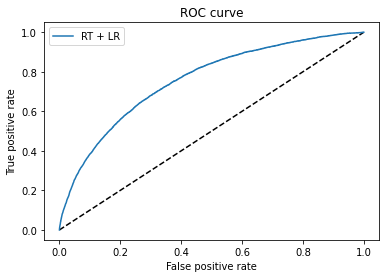

In [107]:
# 可視化
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# テストで予測、kaggleに投稿

model_gbm.predict_proba()

In [89]:
test_data = pd.read_csv("application_test.csv")

test_df = test_data.drop(['SK_ID_CURR'], axis=1)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [91]:
_factorize_categoricals(test_df, obj)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,-1,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,0,0,121500.0,412560.0,17473.5,270000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,0,0,0,1,2,157500.0,622413.0,31909.5,495000.0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,0,0,1,0,1,202500.0,315000.0,33205.5,315000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,0,1,0,1,0,225000.0,450000.0,25128.0,450000.0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [94]:
# 欠損値を中央値で置換
test_df.fillna(test_df.median(), inplace=True)
test_df

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,-1,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,0,0,121500.0,412560.0,17473.5,270000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,0,0,0,1,2,157500.0,622413.0,31909.5,495000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48741,0,0,1,0,1,202500.0,315000.0,33205.5,315000.0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,0,1,0,1,0,225000.0,450000.0,25128.0,450000.0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [100]:
# XXに代入
XX = test_df.values

In [101]:
pred = model_gbm.predict(XX)
prob = model_gbm.predict_proba(XX)[:,1]

In [102]:
tmp = pd.DataFrame(prob, columns=["TARGET"])
tmp

,TARGET
0,0.409499
1,0.412598
2,0.178128
3,0.146395
4,0.553018
...,...
48739,0.265600
48740,0.401506
48741,0.154451
48742,0.402015


In [104]:
submit = pd.concat([test_data['SK_ID_CURR'], tmp["TARGET"]], axis=1)
submit

,SK_ID_CURR,TARGET
0,100001,0.409499
1,100005,0.412598
2,100013,0.178128
3,100028,0.146395
4,100038,0.553018
...,...,...
48739,456221,0.265600
48740,456222,0.401506
48741,456223,0.154451
48742,456224,0.402015


In [105]:
# kaggle用にCSV出力
submit.to_csv('kaggle_submit_003.csv', index=False)

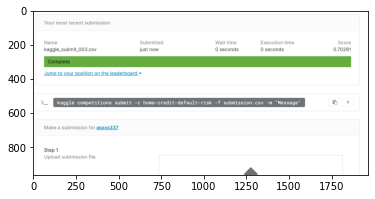

In [108]:
# 提出結果
%matplotlib inline
 
import matplotlib.image as mpimg
plt.imshow(mpimg.imread("submit003.png"))

score : 0.70291だった。

パラメータの調整のみでの結果なので、特徴量エンジニアリングをちゃんとやればもっと伸びそう。